In [162]:
import xarray as xr
import numpy as np
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling
from isca_tools.utils import print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm import tqdm

In [58]:
# Plotting info
ar = 4/3        # aspect ratio (width/height)
im_sz = 2.5     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [112]:
# exp_name = 'e.e20.E1850TEST.f09_g17.test'
exp_name = 'e.e20.ETEST.f19_g17.test_daily_output'
var_keep = ['TS', 'FSNTOA', 'FLNT', 'gw', 'T']
ds_monthly = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, months_keep=[1]).load()
ds = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, hist_file=1).load()
ds_lnd = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, hist_file=1, comp='lnd').load()

In [267]:
ds.hybm.isel(lev=-4)

<xarray.DataArray 'hybm' (time: 41)> Size: 328B
array([0.92512384, 0.92512384, 0.92512384, 0.92512384, 0.92512384,
       0.92512384, 0.92512384, 0.92512384, 0.92512384, 0.92512384,
       0.92512384, 0.92512384, 0.92512384, 0.92512384, 0.92512384,
       0.92512384, 0.92512384, 0.92512384, 0.92512384, 0.92512384,
       0.92512384, 0.92512384, 0.92512384, 0.92512384, 0.92512384,
       0.92512384, 0.92512384, 0.92512384, 0.92512384, 0.92512384,
       0.92512384, 0.92512384, 0.92512384, 0.92512384, 0.92512384,
       0.92512384, 0.92512384, 0.92512384, 0.92512384, 0.92512384,
       0.92512384])
Coordinates:
    lev      float64 8B 936.2
  * time     (time) object 328B 0001-01-01 00:00:00 ... 0001-02-10 00:00:00
Attributes:
    long_name:  hybrid B coefficient at layer midpoints

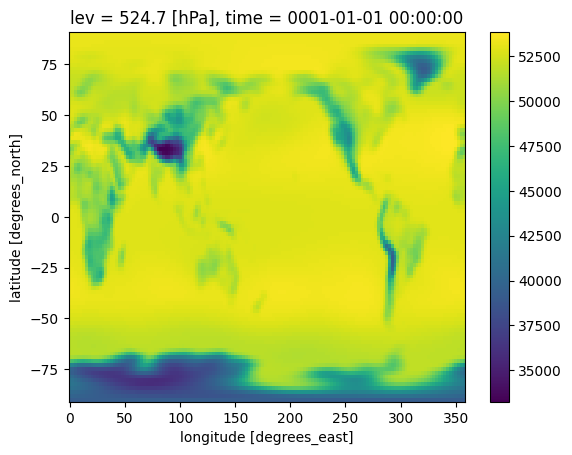

In [254]:
(ds_monthly.hyam*ds_monthly.P0 + ds_monthly.hybm*ds_monthly.PS).isel(lev=ind_ft).plot()

In [249]:
print_ds_var_list(ds_monthly, 'hyb')

hyam: hybrid A coefficient at layer midpoints
hybm: hybrid B coefficient at layer midpoints
hyai: hybrid A coefficient at layer interfaces
hybi: hybrid B coefficient at layer interfaces


In [113]:
p_ft_approx = 500
p_surf_approx = 1000
ind_ft = int(np.argmin(np.abs(ds.T.lev-p_ft_approx).to_numpy()))
ind_surf = int(np.argmin(np.abs(ds.T.lev-p_surf_approx).to_numpy()))
p_ft = float(ds.T.lev[ind_ft])*100
p_surf = float(ds.T.lev[ind_surf])*100

## Select Regions for Quantile Analysis

In [124]:
reg_name = ['Pacific Tropics', 'Congo', 'Indonesia', 'Brazil', 'Sahara', 'India', 'Mexico', 'Saudi', 'Australia', 
            'Pacific Subtropics N', 'Pacific Subtropics S']
reg_lat = [0, 0, 0, -10, 23, 23, 23, 23, -23, 23, -23]
reg_lon = [360-148, 25, 115, 360-53, 13, 78, 360-102, 45, 134, 360-148, 360-148]
n_reg = len(reg_name)
reg_lat_ind = [np.argmin(np.abs(ds.lat-reg_lat[i]).to_numpy()) for i in range(n_reg)]
reg_lon_ind = [np.argmin(np.abs(ds.lon-reg_lon[i]).to_numpy()) for i in range(n_reg)]
reg_sz_lat = 2      # region covers from central latitude to +/- this many points in lat direction
reg_sz_lon = 2      # region covers from central latitude to +/- this many points in lon direction

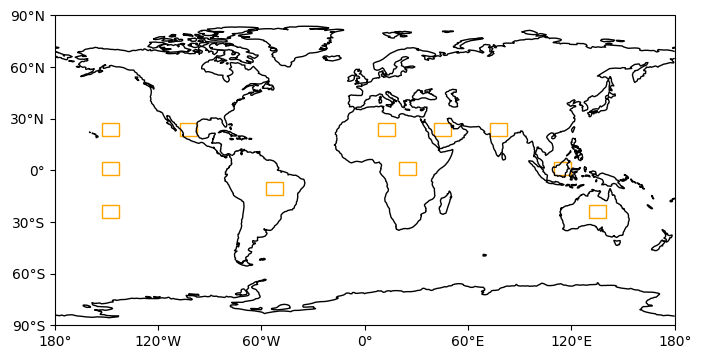

In [125]:
fig = plt.figure(figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_xticks([-240, -180, -120, -60, 0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
for i in range(n_reg):
    lat_sq = ds.lat.isel(lat=slice(reg_lat_ind[i]-reg_sz_lat, reg_lat_ind[i]+reg_sz_lat+1)).to_numpy()
    lon_sq = ds.lon.isel(lon=slice(reg_lon_ind[i]-reg_sz_lon, reg_lon_ind[i]+reg_sz_lon+1)).to_numpy()
    lat_sz = lat_sq[-1] - lat_sq[0]
    lon_sz = lon_sq[-1] - lon_sq[0]
    if lon_sq[0]>180:
        sq = patches.Rectangle((lon_sq[0]-360, lat_sq[0]), lon_sz, lat_sz, edgecolor='orange', facecolor='none')
    else:
        sq = patches.Rectangle((lon_sq[0], lat_sq[0]), lon_sz, lat_sz, edgecolor='orange', facecolor='none')
    ax.add_patch(sq)

## Get Quantile Info at each region
For MSE based theory, need to know various variables conditioned on near-surface temperature percentile

In [248]:
ind_ft

20

In [218]:
quant_use = [90, 95, 99]
n_quant = len(quant_use)
i=0
j=0
output_info = {var: np.zeros((n_reg, n_quant)) for var in  ['temp', 'temp_ft', 'sphum', 'z', 'z_ft', 'mse', 'mse_sat_ft', 'epsilon', 
                                                            'soil_liq']}
for var in ['temp', 'temp_ft', 'sphum', 'z', 'z_ft', 'mse', 'mse_sat_ft', 'epsilon', 'soil_liq']:
    output_info[var+'_std'] = np.zeros((n_reg, n_quant))
output_info['lat_lon_most_common'] = np.zeros((n_reg, n_quant, 2))
output_info['lat_lon_most_common_freq'] = np.zeros((n_reg, n_quant, 3))
with tqdm(total=n_quant*n_reg, position=0, leave=True) as pbar:
    for i in range(n_reg):
        ds_use = ds.isel(lat=slice(reg_lat_ind[i]-reg_sz_lat, reg_lat_ind[i]+reg_sz_lat+1), 
                         lon=slice(reg_lon_ind[i]-reg_sz_lon, reg_lon_ind[i]+reg_sz_lon+1))
        ds_use = ds_use.stack(lon_lat_time=("lon", "lat", "time"), create_index=False).chunk(dict(lon_lat_time=-1))
        soil_liq_use = ds_lnd.SOILLIQ.sum(dim='levsoi').stack(lon_lat_time=("lon", "lat", "time"), 
                                                              create_index=False).chunk(dict(lon_lat_time=-1))
        for j in range(n_quant):
            # get indices corresponding to given near-surface temp quantile
            use_ind = get_quant_ind(ds_use.T.isel(lev=ind_surf), quant_use[j], 0.5, 0.5)     
            n_days_use = len(use_ind)
            var_use = {}
            var_use['temp'] = ds_use.T.isel(lev=ind_surf, lon_lat_time=use_ind)
            var_use['temp_ft'] = ds_use.T.isel(lev=ind_ft, lon_lat_time=use_ind)
            var_use['sphum'] = ds_use.Q.isel(lev=ind_surf, lon_lat_time=use_ind)
            var_use['z'] = ds_use.Z3.isel(lev=ind_surf, lon_lat_time=use_ind)
            var_use['z_ft'] = ds_use.Z3.isel(lev=ind_ft, lon_lat_time=use_ind)
            var_use['mse'] = moist_static_energy(ds_use.T.isel(lev=ind_surf), ds_use.Q.isel(lev=ind_surf), 
                                                 ds_use.Z3.isel(lev=ind_surf)).isel(lon_lat_time=use_ind)
            var_use['mse_sat_ft'] = moist_static_energy(ds_use.T.isel(lev=ind_ft), sphum_sat(ds_use.T.isel(lev=ind_ft), p_ft), 
                                                        ds_use.Z3.isel(lev=ind_ft)).isel(lon_lat_time=use_ind)
            var_use['epsilon'] = var_use['mse'] - var_use['mse_sat_ft']
            var_use['soil_liq'] = soil_liq_use.isel(lon_lat_time=use_ind)
            for key in var_use:
                output_info[key][i, j] = var_use[key].mean()
                output_info[key+'_std'][i, j] = var_use[key].std()
            lat_lon_use = np.unique(np.vstack((ds_use.lat[use_ind], ds_use.lon[use_ind])), axis=1, return_counts=True)
            
            # Record most common specific coordinate within grid to see if most of days are at a given location
            output_info['lat_lon_most_common'][i, j] = lat_lon_use[0][:, lat_lon_use[1].argmax()]
            output_info['lat_lon_most_common_freq'][i, j] = lat_lon_use[1][lat_lon_use[1].argmax()]
            pbar.update(1)

100%|██████████| 33/33 [00:02<00:00, 13.71it/s]


In [228]:
# Add basic info of the dataset and averaging details used
output_info['lat'] = ds.lat.to_numpy()
output_info['lon'] = ds.lon.to_numpy()
output_info['pressure_surf'] = p_surf
output_info['pressure_ft'] = p_ft
output_info['quant'] = quant_use
output_info['reg_name'] = reg_name
output_info['reg_lat_ind'] = reg_lat_ind
output_info['reg_lon_ind'] = reg_lon_ind
output_info['reg_sz_lat'] = reg_sz_lat
output_info['reg_sz_lon'] = reg_sz_lon
output_info['n_days_use'] = n_days_use

In [238]:
# Save file
# np.savez_compressed('/Users/joshduffield/Desktop/hi_compress.npz', **output_info)
# np.load('/Users/joshduffield/Desktop/hi_compress.npz')